## Checklist

* Loads data from the original source on the web 
* Wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
* Performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
* Creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
* Performs the data analysis
* Creates a visualization of the analysis


note: all tables and figure should have a figure/table number and a legend

## Plan

* Short intro to loading data and libraries that are to be used
* Talk about data cleaning, and removing values that may be irrelevant
* Talk about predictors, use graphs to see possible patterns
* Link health stuff to our model, use those variables as a base
* Talk about the experimenting with extra predictors and the conclusion of the best predictors found
* Conclusion that 16 is the best number and that 64.8% is the best we could get with this data set

# Methods and Results

In [14]:
library(tidyverse)
library(tidymodels)
library(readxl)
library(dplyr)
library(tidyclust)
library(repr)
library(GGally)

In [15]:
data <- read_excel('data/heart_disease.xlsx')
head(data)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0


Table 1 Read heart disease excel data 

In [16]:
heart_data <- data|> 
    rename(diagnosis = num) |> #Renames num to Diagnosis
    mutate(ca = as.numeric(ca), thal = as.numeric(thal), diagnosis = as.factor(diagnosis)) |> #Formats table
    na.omit()

head(heart_data)

heart_data_clean <- heart_data |>
    select(age, trestbps, chol, thalach, oldpeak, thal, diagnosis, sex, exang, ca, slope)

head(heart_data_clean)

Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `ca = as.numeric(ca)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0


age,trestbps,chol,thalach,oldpeak,thal,diagnosis,sex,exang,ca,slope
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
63,145,233,150,2.3,6,0,1,0,0,3
67,160,286,108,1.5,3,2,1,1,3,2
67,120,229,129,2.6,7,1,1,1,2,2
37,130,250,187,3.5,3,0,1,0,0,3
41,130,204,172,1.4,3,0,0,0,0,1
56,120,236,178,0.8,3,0,1,0,0,1


Table 1.1 Changed variable types to the types necessary for the planned analysis

## Analysis of predictors

In predictive modeling for coronary artery heart disease (CAD), the selection of input variables critically influences the efficacy and accuracy of the model. Our K-Nearest Neighbors (KNN) prediction model prioritizes clinical predictors substantiated by empirical evidence for their strong association with CAD. Among numerous potential predictors, five have been identified as particularly significant: age, sex, exercise-induced angina(exang), ST depression(oldpeak), and the number of major vessels with observable calcium during fluoroscopy(ca).

Age is a fundamental predictor of CAD, with the incidence of the disease escalating with increasing age (Ayatollahi et al., 2019, p. 2). This finding is mirrored by Detrano et al. (1989, p. 305), who incorporated age as a variable in their probability models for the diagnosis of CAD. The progressive nature of cardiovascular risk factors over time solidifies age as a paramount indicator for our KNN model.

Sex has been consistently identified as a differentiator in CAD prevalence, with distinct patterns observed between genders (Ayatollahi et al., 2019, p. 2). Similarly, Detrano et al. (1989, p. 305) included sex as a discrete variable, acknowledging its influence on the clinical presentation and prognosis of heart disease.

Exercise-induced angina (exang), symptomatic of myocardial ischemia, is indicative of significant coronary obstruction and has been directly incorporated into predictive assessments of CAD (Detrano et al., 1989, p. 305). The acuteness of this symptom in reflecting cardiovascular distress renders it a critical component for inclusion in our KNN model.

ST depression (oldpeak), quantified during stress tests, signals myocardial ischemia and has been employed by Detrano et al. (1989, p. 305) in their diagnostic algorithms. Its role in indicating the severity of ischemia, which is crucial in the evaluation of CAD, makes it an indispensable predictor for our analysis.

Lastly, the number of major vessels (ca) identified with calcium during fluoroscopy, a direct measure of coronary artery blockages, is considered a potent predictor of CAD (Detrano et al., 1989, p. 305). This variable provides a quantifiable assessment of disease extent, significantly enhancing the prognostic value of our model.


These predictors are statistically significant and possess high clinical relevance, offering a focused and medically informed basis for our KNN predictive model, free from the clutter of less impactful variables.

### References
[1] Ayatollahi, H., Gholamhosseini, L., & Salehi, M. (2019). Predicting coronary artery disease: A comparison between two data mining algorithms. BMC Public Health, 19(1), 448-448. https://doi.org/10.1186/s12889-019-6721-5


[2] Detrano, R., Janosi, A., Steinbrunn, W., Pfisterer, M., Schmid, J., Sandhu, S., Guppy, K. H., Lee, S., & Froelicher, V. (1989). International application of a new probability algorithm for the diagnosis of coronary artery disease. The American Journal of Cardiology, 64(5), 304-310. https://doi.org/10.1016/0002-9149(89)90524-9


In [17]:
summary_table <- heart_data |>
      group_by(diagnosis) |>
      summarise(across(where(is.numeric), list(mean = ~mean(.x, na.rm = TRUE))),
            Count = n())

summary_table

diagnosis,age_mean,sex_mean,cp_mean,trestbps_mean,chol_mean,fbs_mean,restecg_mean,thalach_mean,exang_mean,oldpeak_mean,slope_mean,ca_mean,thal_mean,Count
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,52.64375,0.5562500,2.793750,129.1750,243.4938,0.14375000,0.8437500,158.5813,0.1437500,0.598750,1.412500,0.2750000,3.787500,160
1,55.61111,0.8333333,3.333333,133.2778,249.1481,0.05555556,1.1481481,145.9815,0.4444444,1.022222,1.629630,0.7407407,5.314815,54
2,58.20000,0.8000000,3.742857,134.3714,260.8571,0.22857143,0.9428571,135.0000,0.6000000,1.802857,1.885714,1.2571429,6.028571,35
3,56.00000,0.8000000,3.771429,135.4571,246.4571,0.22857143,1.2857143,132.0571,0.6571429,1.962857,1.971429,1.4571429,6.285714,35
4,59.69231,0.8461538,3.692308,138.7692,253.3846,0.07692308,1.6153846,140.6154,0.4615385,2.361538,2.076923,1.6923077,6.230769,13


Table 1.2 IDK what exactly is going on here

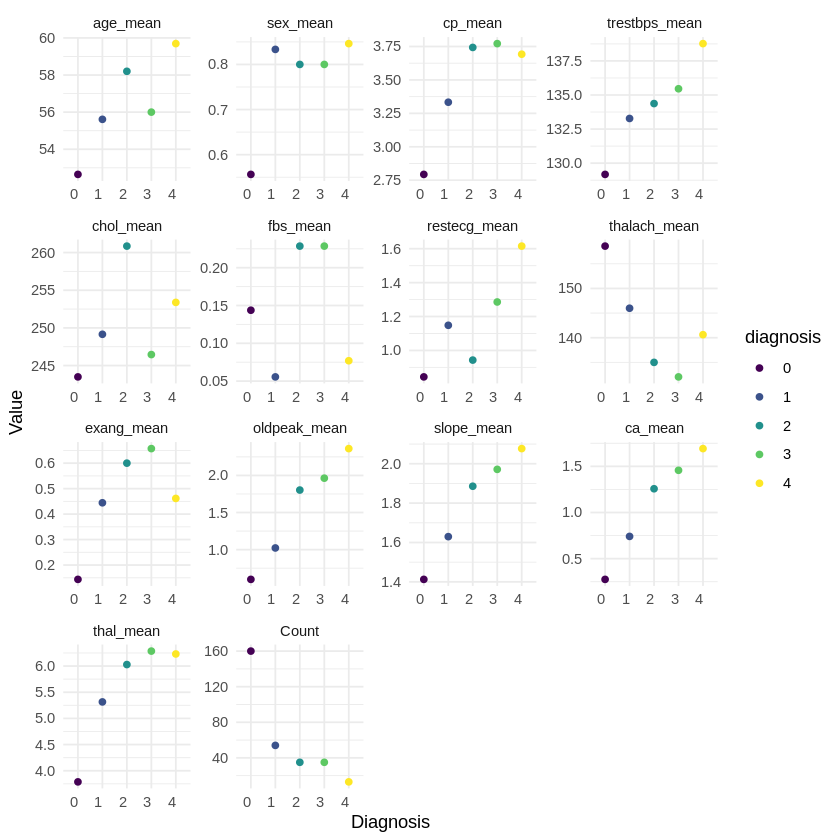

In [18]:
st_long <- reshape2::melt(summary_table, id.vars = 'diagnosis')

summary_plot <- ggplot(st_long, aes(x = diagnosis, y = value, color = diagnosis)) +
  geom_point() + 
  facet_wrap(variable ~., scales = "free") + 
  labs(x = "Diagnosis", y = "Value") +
  theme_minimal() +
  theme(
    strip.text.x = element_text(angle = 0, hjust = 0.5),
    axis.text.x = element_text(angle = 0, hjust = 1)
  ) +
  scale_color_viridis_d()

summary_plot

Fig 1 Diagnosis vs Predictors (Mean) plot

In [23]:
set.seed(9998)

heart_split <- initial_split(heart_data_clean, prop = 0.80, strata = diagnosis)  
heart_train <- training(heart_split)   
heart_test <- testing(heart_split)

heart_train |>
    slice(0:5)
heart_test |> 
    slice(0:5)

age,trestbps,chol,thalach,oldpeak,thal,diagnosis,sex,exang,ca,slope
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
63,145,233,150,2.3,6,0,1,0,0,3
37,130,250,187,3.5,3,0,1,0,0,3
41,130,204,172,1.4,3,0,0,0,0,1
56,120,236,178,0.8,3,0,1,0,0,1
57,120,354,163,0.6,3,0,0,1,0,1


age,trestbps,chol,thalach,oldpeak,thal,diagnosis,sex,exang,ca,slope
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
44,120,263,173,0.0,7,0,1,0,0,1
52,172,199,162,0.5,7,0,1,0,0,1
64,110,211,144,1.8,3,0,1,1,0,2
58,132,224,173,3.2,7,3,1,0,2,1
64,140,335,158,0.0,3,1,1,0,0,1


Table 1.3 & 1.4 Split heart data into training and testing

### Application with K-NN Algorithm



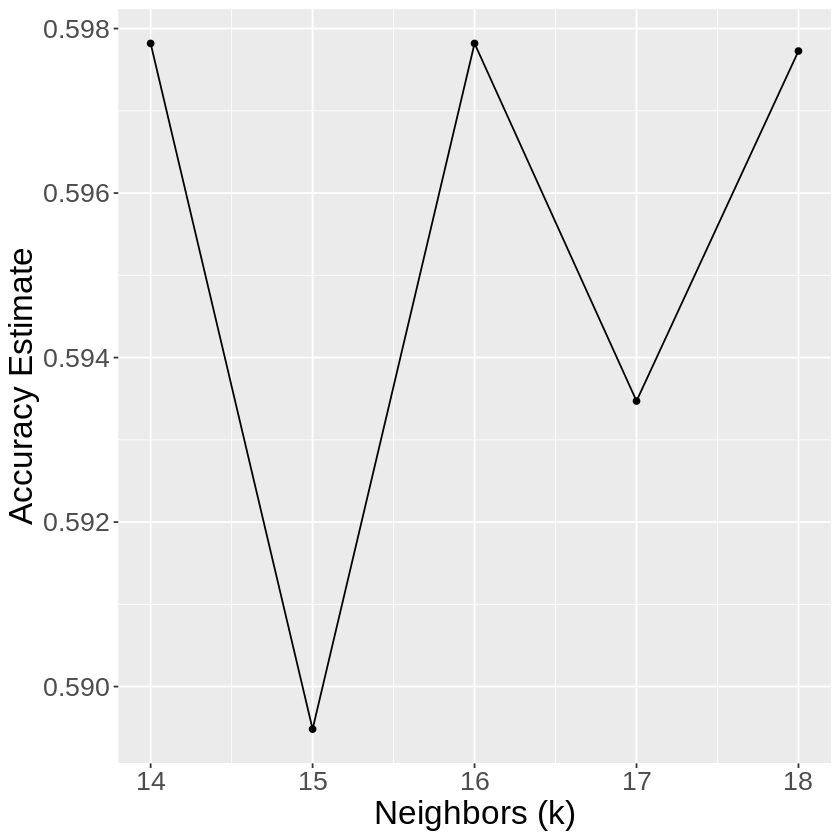

In [24]:
# KNN Steps
# Cross-Validation
set.seed(9998)
heart_vfold <- vfold_cv(heart_train, v = 5, strata = diagnosis)
k_vals <- tibble(neighbors = c(14, 15, 16, 17, 18)) # K-Values you want to test out

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

heart_recipe <- recipe(diagnosis ~ ., data = heart_train) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())


heart_fit <- workflow() |>
                     add_recipe(heart_recipe) |>
                     add_model(knn_spec) |>
                     tune_grid(resamples = heart_vfold, grid = k_vals)

heart_results <- collect_metrics(heart_fit)

accuracies <- heart_results |>
              filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors (k)", y = "Accuracy Estimate") +
       theme(text = element_text(size = 20)) 
       # scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
       # scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis
cross_val_plot
# K = 16 is the best K - value

Fig 1.1 Estimated accuracy versus the neighbors (K). K = 16 gives the best accuracy.

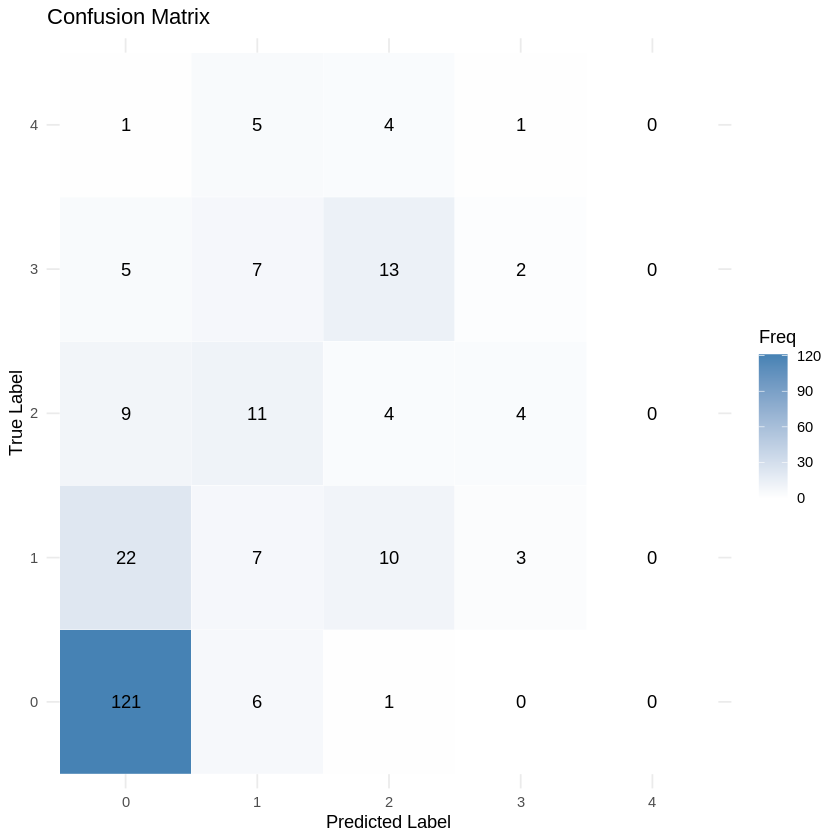

In [30]:
# Define the KNN model with k = 16
final_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 16) |>
            set_engine("kknn") |>
            set_mode("classification")



# Create a new workflow with the final KNN specification
final_workflow <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(final_knn_spec)

# Fit the final model on the entire test dataset
final_fit <- fit(final_workflow, data = heart_test)

# Predict using the fitted model
predictions <- predict(final_fit, new_data = heart_train, type = "class") |>
    bind_cols(heart_train)

# Create confusion matrix
conf_mat <- table(Truth = predictions$diagnosis, Prediction = predictions$.pred_class)

# Convert the confusion matrix to a tidy format for ggplot
conf_mat_df <- as.data.frame(as.table(conf_mat))

# Plotting
ggplot(data = conf_mat_df, aes(x = Prediction, y = Truth, fill = Freq)) +
    geom_tile(color = "white") +
    geom_text(aes(label = Freq), color = "black") +  
    scale_fill_gradient(low = "white", high = "steelblue") +  # Color gradient for visual emphasis
    labs(title = "Confusion Matrix", x = "Predicted Label", y = "True Label") +
    theme_minimal()

Fig 1.2 Confusion Matrix